# 02 Marker Gene Analysis & Embedding Exploration

This notebook:
- Identifies top marker genes for each cell type.
- Visualizes expression patterns.
- Explores dataset structure with PCA/UMAP.


In [1]:
!pwd

/mnt/d/Study/Python Scripts/scimilarity-finetune


# Imports and setup

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mygene

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


# Load dataset

In [3]:
adata = sc.read_h5ad("data/raw/dataset.h5ad")  
label_col = 'cell_type'

# Identify top marker genes per cell type

In [ ]:
# Clear any raw data
adata.raw = None

# Normalize counts per cell
sc.pp.normalize_total(adata, target_sum=1e4) # source: https://www.10xgenomics.com/analysis-guides/single-cell-rna-seq-data-normalization

# Log-transform
sc.pp.log1p(adata)

# Compute top 5 marker genes per cell type
sc.tl.rank_genes_groups(adata, groupby=label_col, method='t-test')  # stores data in adata.uns

# Convert results to DataFrame
marker_df = pd.DataFrame({
    group: adata.uns['rank_genes_groups']['names'][group][:5]
    for group in adata.obs[label_col].unique()
})
marker_df

,fibroblast,pericyte,microglial cell,oligodendrocyte,smooth muscle cell,glutamatergic neuron,endothelial cell of artery,astrocyte,T cell,capillary endothelial cell,vein endothelial cell,oligodendrocyte precursor cell,GABAergic neuron,perivascular macrophage
0,ENSG00000122870,ENSG00000164741,ENSG00000138639,ENSG00000184226,ENSG00000185532,ENSG00000078328,ENSG00000085276,ENSG00000185737,ENSG00000141293,ENSG00000102755,ENSG00000085563,ENSG00000171587,ENSG00000174469,ENSG00000124491
1,ENSG00000069667,ENSG00000113231,ENSG00000120594,ENSG00000169306,ENSG00000151067,ENSG00000183117,ENSG00000185305,ENSG00000185565,ENSG00000151883,ENSG00000110799,ENSG00000182463,ENSG00000183117,ENSG00000170579,ENSG00000248905
2,ENSG00000140538,ENSG00000069667,ENSG00000077420,ENSG00000147488,ENSG00000172572,ENSG00000179915,ENSG00000184005,ENSG00000182667,ENSG00000081237,ENSG00000085563,ENSG00000164181,ENSG00000187416,ENSG00000021645,ENSG00000163694
3,ENSG00000249307,ENSG00000173638,ENSG00000107099,ENSG00000183230,ENSG00000184347,ENSG00000067715,ENSG00000144724,ENSG00000151322,ENSG00000112576,ENSG00000206190,ENSG00000047617,ENSG00000116147,ENSG00000102466,ENSG00000181804
4,ENSG00000103888,ENSG00000171408,ENSG00000082074,ENSG00000155886,ENSG00000140836,ENSG00000170579,ENSG00000170011,ENSG00000066032,ENSG00000198804,ENSG00000164181,ENSG00000110799,ENSG00000148948,ENSG00000185737,ENSG00000177575


# Gene mapping

In [5]:
top_genes = marker_df.values.flatten().tolist()  # flatten to list

mg = mygene.MyGeneInfo()
result = mg.querymany(top_genes, scopes='ensembl.gene', fields='symbol,name', species='human')

result_df = pd.DataFrame(result)[['query','symbol','name']]
result_df

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
7 input query terms found dup hits:	[('ENSG00000185737', 2), ('ENSG00000085563', 2), ('ENSG00000069667', 2), ('ENSG00000183117', 2), ('E


,query,symbol,name
0,ENSG00000122870,BICC1,BicC family RNA binding protein 1
1,ENSG00000164741,DLC1,DLC1 Rho GTPase activating protein
2,ENSG00000138639,ARHGAP24,Rho GTPase activating protein 24
3,ENSG00000184226,PCDH9,protocadherin 9
4,ENSG00000185532,PRKG1,protein kinase cGMP-dependent 1
...,...,...,...
65,ENSG00000164181,ELOVL7,ELOVL fatty acid elongase 7
66,ENSG00000110799,VWF,von Willebrand factor
67,ENSG00000148948,LRRC4C,leucine rich repeat containing 4C
68,ENSG00000185737,NRG3,neuregulin 3


# Visualize marker expression

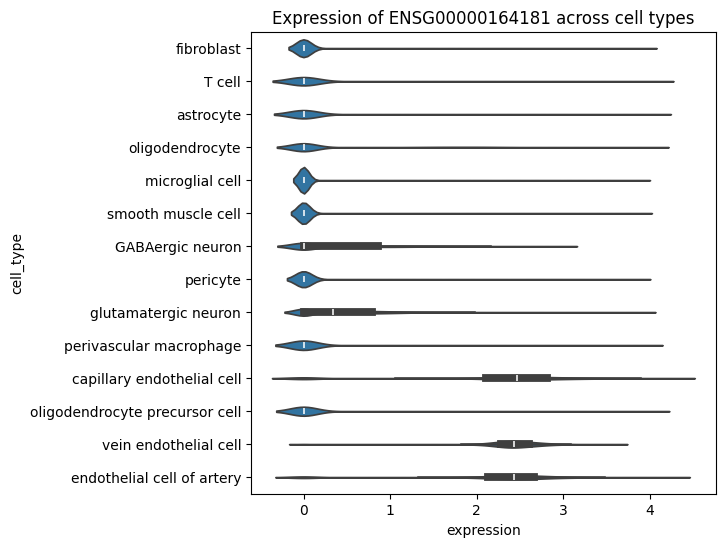

In [12]:
# Find Ensembl ID 
ensembl_id = result_df[result_df['symbol']=='ELOVL7']['query'].values[0]

# Convert adata to tidy DataFrame
gene_values = adata[:, ensembl_id].X.toarray().flatten()  # expression for that gene
df = pd.DataFrame({
    'expression': gene_values,
    'cell_type': adata.obs['cell_type'].values
})

# violin plot
plt.figure(figsize=(6,6))
sns.violinplot(x='expression', y='cell_type', data=df, orient='h')
plt.title(f'Expression of {ensembl_id} across cell types')
plt.show()

# UMAP visualization

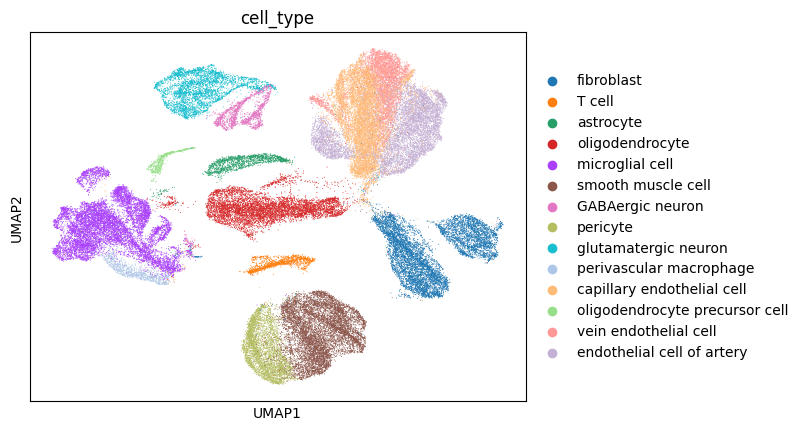

In [8]:
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

# Color by cell type
sc.pl.umap(adata, color=label_col)

# Summary
- Top marker genes per cell type identified.
- Violin plots show expression distributions.
- UMAP confirms separation of most cell types.